# Call Annotations

In [92]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import liana as li
from liana.mt import lr_basis

In [93]:
from utils import run_rf_auc

In [94]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')
dataset_name = 'CID4535'
# slide_names = ['1142243F', '1160920F', 'CID4290', 'CID44971', 'CID4535'] # 'CID4465' really unbalanced

In [95]:
function_names = li.mt.sp.show_functions()['name']
function_names = list(function_names[~function_names.str.contains('masked')]) + ['masked_spearman']

In [96]:
function_names

['pearson', 'spearman', 'cosine', 'jaccard', 'morans', 'masked_spearman']

In [97]:
adata = sc.read_h5ad(os.path.join(data_dir, f"{dataset_name}.h5ad"))

In [98]:
adata.uns['function_names'] = function_names

In [99]:
print(adata.obs['Classification'].value_counts())

Invasive cancer                                   418
Invasive cancer + lymphocytes                     361
Stroma                                            169
Uncertain                                          73
Lymphocytes                                        69
Artefact                                           23
Adipose tissue                                      8
Invasive cancer + adipose tissue + lymphocytes      3
Name: Classification, dtype: int64


In [100]:
adata.obs['Classification'][adata.obs['Classification'].isna()] = 'Artefact'
adata.obs['spot_label'] = adata.obs['Classification'].str.contains('cancer').astype(int)

Preprocess

In [101]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=20)

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [102]:
sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)

In [103]:
adata

AnnData object with n_obs × n_vars = 1127 × 14185
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'ident', 'in_tissue', 'array_row', 'array_col', 'nCount_RNA', 'nFeature_RNA', 'subtype', 'patientid', 'Classification', 'spot_label', 'n_genes'
    var: 'n_cells'
    uns: 'X_name', 'spatial', 'function_names', 'log1p', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

Run all functions

In [104]:
## Run LR basis
for function_name in function_names:
    print(f"Running {function_name}")
    
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6, set_diag=True)
    
    lr_basis(adata, function_name=function_name,
                obsm_added=function_name, key_added= function_name,
                use_raw=False, proximity_key="spatial_connectivities"
                )
    
    ## TODO Ligand-Target

Running pearson
Running spearman
Running cosine
Running jaccard
Running morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman


In [86]:
run_rf_auc(adata, dataset_name)

Fold: 0
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 1
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 2
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 3
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 4
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 5
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 6
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 7
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
Fold: 8
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans
Running masked_spearman
F

In [87]:
import plotnine as p9

In [88]:
performance = adata.uns['performance']

In [89]:
os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
adata.uns['performance'].to_csv(os.path.join(data_dir, 'results', f"{dataset_name}_performance.csv"))

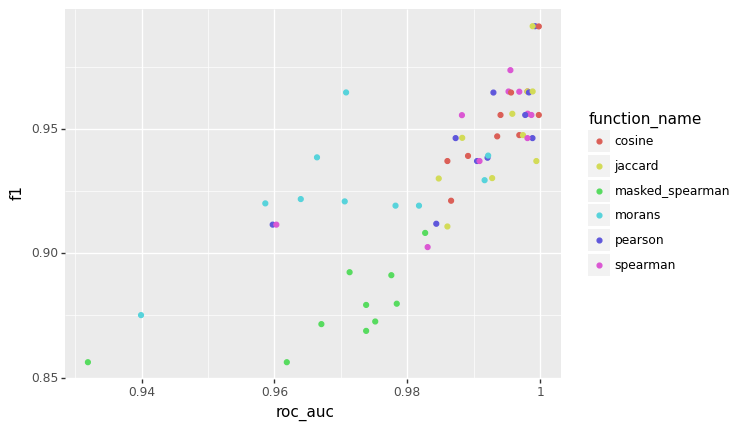

<ggplot: (8757434890523)>

In [90]:
# scatter plot of function_name, x roc_auc, y f1
p9.ggplot(performance, p9.aes(x='roc_auc', y='f1', colour='function_name')) + p9.geom_point()

In [91]:
performance

,dataset_name,function_name,roc_auc,f1,oob_score,train_index,test_index
0,CID44971,pearson,0.992096,0.938491,0.936842,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
1,CID44971,spearman,0.996875,0.965065,0.925359,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
2,CID44971,cosine,0.996875,0.947598,0.940670,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
3,CID44971,jaccard,0.997426,0.947598,0.953110,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
4,CID44971,morans,0.963971,0.921852,0.925359,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
5,CID44971,masked_spearman,0.971324,0.892415,0.874641,"[0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...","[1, 4, 12, 21, 31, 33, 38, 42, 44, 54, 61, 71,..."
6,CID44971,pearson,0.959743,0.911566,0.936842,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15...","[7, 11, 39, 56, 81, 92, 98, 100, 121, 137, 167..."
7,CID44971,spearman,0.960294,0.911566,0.930144,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15...","[7, 11, 39, 56, 81, 92, 98, 100, 121, 137, 167..."
8,CID44971,cosine,0.989154,0.939218,0.955024,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15...","[7, 11, 39, 56, 81, 92, 98, 100, 121, 137, 167..."
9,CID44971,jaccard,0.984743,0.930131,0.960766,"[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15...","[7, 11, 39, 56, 81, 92, 98, 100, 121, 137, 167..."


TODO: Ligand-Target